In [32]:
from fonctions import *
import pandas as pd
import matplotlib.pyplot as plt


## 1. Chargement et préprocessing des données


In [33]:
# Chargement du train
train_df = pd.read_csv("train.csv", sep="\t")


### Sélection des colonnes quantitatives pour les caractéristiques (features).


In [34]:
num_cols = [
    "danceability",  # Mesure de la capacité à danser (0 à 1)
    "energy",  # Intensité et activité globale de la piste
    "key",  # Tonalité musicale (0 à 11)
    "loudness",  # Niveau sonore moyen en décibels
    "mode",  # Mode (majeur = 1, mineur = 0)
    "speechiness",  # Mesure de la présence de paroles
    "acousticness",  # Probabilité qu'il s'agisse d'une piste acoustique
    "instrumentalness",  # Mesure de l'absence de paroles
    "liveness",  # Probabilité qu'il s'agisse d'un enregistrement live
    "valence",  # Mesure de la positivité musicale (0 à 1)
    "tempo",  # Tempo de la piste en battements par minute (BPM)
    "duration_ms",  # Durée de la piste en millisecondes
]

# Extraction des caractéristiques (X) et des étiquettes (y) à partir du DataFrame d'entraînement.
X = train_df[num_cols].values  # Matrice des valeurs des colonnes quantitatives
y = train_df["playlist_genre"].values  # Vecteur des étiquettes de genres de playlist


### Encodage manuel des labels pour convertir les genres en indices numériques.


In [35]:
# Extraction des genres uniques présents dans y
unique_genres = np.unique(y)

# Création d'un mapping genre -> index
genre_to_idx = {g: i for i, g in enumerate(unique_genres)}

# Conversion des genres en indices numériques
y_encoded = np.array([genre_to_idx[g] for g in y])

# Calcul du nombre total de classes (genres uniques).
num_classes = len(unique_genres)


### Normalisation des données (Standardisation) pour avoir une moyenne nulle et un écart-type unitaire.


In [36]:
mean = X.mean(axis=0)  # Calcul de la moyenne pour chaque colonne (caractéristique)
std = X.std(axis=0)  # Calcul de l'écart-type pour chaque colonne


### Standardisation des données : soustraction de la moyenne et division par l'écart-type.


In [37]:
# Une petite constante (1e-9) est ajoutée au dénominateur pour éviter une division par zéro.
X = (X - mean) / (std + 1e-9)


### Séparation des données en ensembles d'entraînement, de validation et de test (70%, 15%, 15% respectivement).


In [38]:
# Séparation Train/Val depuis le train.csv (85% train, 15% val)
n = len(X)  # Nombre total d'exemples
idx = np.arange(n)  # Création d'indices pour les exemples
np.random.shuffle(idx)  # Mélange aléatoire des indices
X = X[idx]  # Réarrangement des caractéristiques selon les indices mélangés
y_encoded = y_encoded[idx]  # Réarrangement des étiquettes correspondantes

train_ratio = 0.85
train_size = int(train_ratio * n)

# Découpage des ensembles
X_train = X[:train_size]  # Données d'entraînement
y_train = y_encoded[:train_size]  # Étiquettes d'entraînement

X_val = X[train_size:]  # Données de validation
y_val = y_encoded[train_size:]  # Étiquettes de validation


In [39]:
# Chargement du test
test_df = pd.read_csv("test.csv", sep="\t")

X_test = test_df[num_cols].values
y_test = test_df["playlist_genre"].values
y_test = np.array([genre_to_idx[g] for g in y_test])  # Encodage avec le même mapping

# On normalise le test avec le mean/std du train
X_test = (X_test - mean) / (std + 1e-9)


## 2. Définition des configurations à tester


LONG : Utilisez ctrl+/ pour décommenter les lignes selectionnées


In [40]:
# layer_configs = [
#     [],  # Pas de couche cachée
#     [2],  # Une couche cachée avec 2 neurone
#     [2, 4, 8, 16, 32, 64],  # etc
#     # [2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2],  # etc
#     [128],
#     [512, 512],
#     [64, 64, 64],
# ]

# batch_sizes = [32, 64, 256]
# learning_rates = [0.01, 0.001, 0.0001]
# dropout_rates = [0.0, 0.5]
# use_batchnorm_options = [False, True]
# clip_norm_values = [None, 1.0]

# results = []  # pour stocker toutes les configurations testées


RAPIDE :


In [41]:
layer_configs = [
    [512, 512],
]

batch_sizes = [32]
learning_rates = [0.01]
dropout_rates = [0.0]
use_batchnorm_options = [True]
clip_norm_values = [1.0]

results = []  # pour stocker toutes les configurations testées


## 3. Boucle d'expérimentation sur plusieurs hyperparamètres


### Boucle d'exploration pour tester différentes configurations hyperparamétriques


In [42]:
for layers in layer_configs:  # Configurations des couches
    for bs in batch_sizes:  # Tailles de mini-lots
        for lr in learning_rates:  # Taux d'apprentissage
            for do_rate in dropout_rates:  # Taux de dropout
                for bn in use_batchnorm_options:  # Batch Normalization
                    for cn in clip_norm_values:  # Valeurs de clip norm

                        # Affichage de la configuration en cours
                        print(
                            f"\nConfiguration: Layers={layers}, Batch={bs}, LR={lr}, Dropout={do_rate}, BN={bn}, ClipNorm={cn}"
                        )
                        # Instanciation du modèle avec les heuristiques
                        model = MLP(
                            # Dimension des caractéristiques
                            input_dim=X_train.shape[1],
                            layer_sizes=layers,  # Taille des couches cachées
                            num_classes=num_classes,  # Nombre de classes
                            dropout_rate=do_rate,  # Taux de dropout
                            use_batchnorm=bn,  # Activation de Batch Normalization
                            clip_norm=cn,  # Valeur de clip norm
                        )

                        # Entraînement du modèle avec les hyperparamètres actuels
                        history = train_model(
                            model,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            epochs=20,  # Nombre d'époques
                            batch_size=bs,  # Taille de mini-lots
                            lr=lr,  # Taux d'apprentissage
                            verbose=False,  # Désactivation de l'affichage détaillé pendant l'entraînement
                        )
                        # Récupération de la précision finale sur l'ensemble de validation
                        val_acc = history["val_acc"][-1]
                        print(f"Validation Accuracy: {val_acc:.4f}")

                        # Stockage des résultats pour cette configuration
                        results.append(
                            (val_acc, layers, bs, lr, do_rate, bn, cn, history, model)
                        )



Configuration: Layers=[512, 512], Batch=32, LR=0.01, Dropout=0.0, BN=True, ClipNorm=1.0


Validation Accuracy: 0.5440


## 4. Extraction des trois meilleures configurations


In [43]:
# Tri des résultats en fonction de la précision de validation (val_acc) en ordre décroissant.
results.sort(key=lambda x: x[0], reverse=True)

# Sélection des 10 meilleures configurations.
top_10 = results[:10]

# Affichage des 10 meilleures configurations avec leurs hyperparamètres et précision.
print("\nTop 10 des configurations (Val Accuracy):")
for i, (val_acc, layers, bs, lr, do_rate, bn, cn, hist, mdl) in enumerate(
    top_10, start=1
):
    print(
        f"{i}) Accuracy = {val_acc:.4f}, Layers = {layers}, Batch = {bs}, LR={lr}, Dropout = {do_rate}, BN = {bn}, ClipNorm = {cn}"
    )



Top 10 des configurations (Val Accuracy):
1) Accuracy = 0.5440, Layers = [512, 512], Batch = 32, LR=0.01, Dropout = 0.0, BN = True, ClipNorm = 1.0


## 5. Tracés des courbes d’apprentissage pour le meilleur modèle


In [44]:
# Extraction de la meilleure configuration parmi le top 10.
(
    best_val_acc,  # Meilleure précision de validation
    best_layers,  # Configuration des couches du réseau
    best_bs,  # Taille de batch
    best_lr,  # Taux d'apprentissage
    best_do,  # Taux de dropout
    best_bn,  # Indicateur Batch Normalization (True/False)
    best_cn,  # Valeur de Clip Norm
    best_history,  # Historique des métriques d'entraînement
    best_model,  # Modèle correspondant à la meilleure configuration
) = top_10[
    0
]  # Sélection de la première configuration parmi les top 10 (meilleure Val Accuracy)


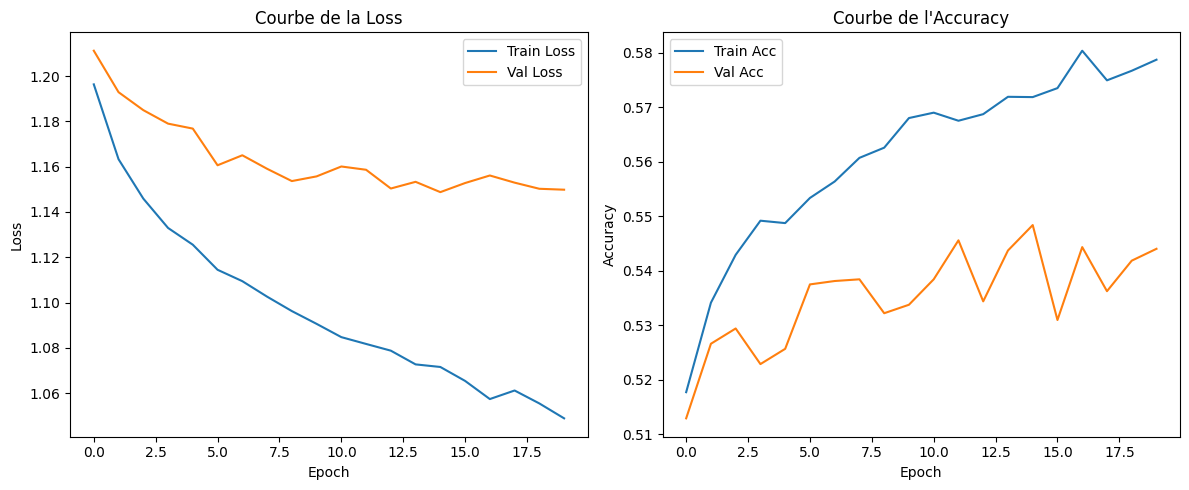

In [45]:
plt.figure(figsize=(12, 5))

# Courbe de la loss (gauche)
plt.subplot(1, 2, 1)
plt.plot(best_history["train_loss"], label="Train Loss")
plt.plot(best_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la Loss")
plt.legend()

# Courbe de l'accuracy (droite)
plt.subplot(1, 2, 2)
plt.plot(best_history["train_acc"], label="Train Acc")
plt.plot(best_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe de l'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## 6. Evaluation finale sur le test


In [46]:
# Calcul des activations finales sur le test set avec le modèle de la meilleure configuration.
test_activations, _, _ = best_model.forward(
    X_test, training=False
)  # Passe avant sans mode entraînement

test_activations = test_activations[
    -1
]  # Récupération des activations finales (sortie softmax)

# Calcul des métriques sur le test set
test_loss = cross_entropy_loss(
    test_activations, y_test
)  # Perte (cross-entropy) sur le test set

test_acc = accuracy(test_activations, y_test)  # Précision sur le test set

# Affichage des résultats finaux avec les métriques et les hyperparamètres de la meilleure configuration.
print(
    f"Performance sur le test set (Meilleure config) :\n"
    f"\tLoss = {test_loss:.4f}\n"  # Affichage de la perte
    f"\tAccuracy = {100 * test_acc:.2f}%\n"  # Affichage de la précision en pourcentage
    f"\nParamètres de la meilleure architecture :\n"
    f"\tCouches = {best_layers}\n"  # Nombre et taille des couches cachées
    f"\tBatch Size = {best_bs}\n"  # Taille des mini-lots
    f"\tLearning Rate = {best_lr}\n"  # Taux d'apprentissage
    f"\tDropout = {best_do}\n"  # Taux de dropout
    f"\tBatchNorm = {best_bn}\n"  # Utilisation de Batch Normalization
    f"\tClipNorm = {best_cn}"  # Valeur de Clip Norm
)


Performance sur le test set (Meilleure config) :
	Loss = 1.1332
	Accuracy = 54.12%

Paramètres de la meilleure architecture :
	Couches = [512, 512]
	Batch Size = 32
	Learning Rate = 0.01
	Dropout = 0.0
	BatchNorm = True
	ClipNorm = 1.0


## 7. Génération d'un fichier CSV avec les prédictions du modèle sur le test.csv


In [47]:
# Prédiction des classes sur le test set
y_pred_idx = best_model.predict(X_test)

# Inverse mapping des indices vers les genres
idx_to_genre = {v: k for k, v in genre_to_idx.items()}
y_pred_genres = [idx_to_genre[idx] for idx in y_pred_idx]

# Création d'une copie du test_df
prediction_df = test_df.copy()

# Remplacement de la colonne "playlist_genre" par les prédictions
prediction_df["playlist_genre"] = y_pred_genres

# Sauvegarde du nouveau CSV avec les prédictions
prediction_df.to_csv("KHALFALLAH_prediction_base.csv", sep="\t", index=False)
print("Fichier 'KHALFALLAH_prediction_base.csv' créé ou modifié avec les prédictions.")


Fichier 'KHALFALLAH_prediction_base.csv' créé avec les prédictions.
